# Import Required Libraries
Import the necessary libraries, such as requests, for making API calls.

In [1]:
# Import the necessary library for making API calls
# Install necessary libraries
'''%pip install requests
%pip install pandas
%pip install datetime
%pip install cudf
%pip install cupy
%pip install openpyxl
%pip install textblob
%pip install transformers
%pip install torch
%pip install import-ipynb'''

# Import libraries
import import_ipynb
from Input_Tools import *
import requests
import pandas as pd
import datetime as dt
import numpy as np
import os as os
from textblob import TextBlob
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib.pyplot as mdates

c:\Users\ravit\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


           date  adjusted_close
0    2023-01-03           13.88
1    2023-01-04           14.11
2    2023-01-05           14.14
3    2023-01-06           15.65
4    2023-01-09           15.65
..          ...             ...
182  2023-09-25            8.41
183  2023-09-26            8.25
184  2023-09-27            8.23
185  2023-09-28            8.25
186  2023-09-29            8.00

[187 rows x 2 columns]
    Ticker  Dividendshare
0  INGA.AS           1.06
1  ASML.AS           6.40
timestamp             1733754600
gmtoffset                      0
datetime     2024-12-09 14:30:00
open                  241.830001
high                      243.36
low                   241.759994
close                     243.25
volume                 1807442.0
Name: 0, dtype: object


# Define API Key
Define the API key

In [2]:
API_Eodhd = "66c0aeb1357b15.87356825"

#Important link: https://eodhd.com/financial-academy/financial-faq/fundamentals-glossary-common-stock


# Running correlation between all the stocks in the exchange
Creates a list of all the correlations betweens stocks and sorts them

In [ ]:
def calculate_and_sort_correlations(tickers_df, exchange, instrument_type="Common Stock", api_token=API_Eodhd, start_date="2025-01-01", end_date="2025-03-30", period="d"):
    """
    Calculate the correlation between all stocks in an exchange and sort them from least to highest.

    Parameters:
        tickers_df (pd.DataFrame): DataFrame containing stock tickers.
        exchange (str): Exchange code to append to tickers (e.g., "US").
        instrument_type (str): Type of the instrument to filter (e.g., "Common Stock").
        api_token (str): API token for authentication.
        start_date (str): Start date for historical data.
        end_date (str): End date for historical data.
        period (str): Period for historical data (e.g., "d" for daily).

    Returns:
        pd.DataFrame: DataFrame containing stock pairs and their correlation, sorted by correlation value.
    """
    # Filter tickers to include only the specified instrument type
    filtered_tickers_df = tickers_df[tickers_df["Type"] == instrument_type]

    stock_data = {}
    for ticker in filtered_tickers_df['Code']:
        try:
            # Combine ticker with exchange code
            full_ticker = f"{ticker}.{exchange}"
            stock_df = Fetch_historical_price(full_ticker, start_date, end_date, period, api_token, columns=["adjusted_close"])
            stock_data[ticker] = stock_df.set_index("date")["adjusted_close"]
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    # Combine all stock data into a single DataFrame
    combined_df = pd.DataFrame(stock_data)

    # Calculate correlation matrix
    correlation_matrix = combined_df.corr()

    # Create a list of all pairs and their correlations
    correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i + 1, len(correlation_matrix.columns)):
            stock1 = correlation_matrix.columns[i]
            stock2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            correlations.append({"Instrument 1": stock1, "Instrument 2": stock2, "Correlation": correlation})

    # Convert the list of correlations to a DataFrame
    correlations_df = pd.DataFrame(correlations)

    # Sort the DataFrame by correlation value
    correlations_df = correlations_df.sort_values(by="Correlation", ascending=True).reset_index(drop=True)

    return correlations_df

# Example usage
tickers = fetch_exchange_symbols("AS")
tickers_subset = tickers
sorted_correlations_df = calculate_and_sort_correlations(tickers_subset, "AS", instrument_type="ETF")
print(sorted_correlations_df)

In [ ]:
#optimized version

import pandas as pd
import numpy as np


def fetch_stock_data(ticker, exchange, start_date, end_date, period, api_token):
    """Helper function to fetch stock data for a single ticker."""
    try:
        full_ticker = f"{ticker}.{exchange}"
        stock_df = Fetch_historical_price(full_ticker, start_date, end_date, period, api_token, columns=["adjusted_close"])
        return ticker, stock_df.set_index("date")["adjusted_close"]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return ticker, None

def calculate_and_sort_correlations(tickers_df, exchange, instrument_type="Common Stock", api_token=API_Eodhd, start_date="2025-01-01", end_date="2025-03-30", period="d"):
    """
    Calculate the correlation between all stocks in an exchange and sort them from least to highest.

    Parameters:
        tickers_df (pd.DataFrame): DataFrame containing stock tickers.
        exchange (str): Exchange code to append to tickers (e.g., "US").
        instrument_type (str): Type of the instrument to filter (e.g., "Common Stock").
        api_token (str): API token for authentication.
        start_date (str): Start date for historical data.
        end_date (str): End date for historical data.
        period (str): Period for historical data (e.g., "d" for daily).

    Returns:
        pd.DataFrame: DataFrame containing stock pairs and their correlation, sorted by correlation value.
    """
    # Filter tickers to include only the specified instrument type
    filtered_tickers_df = tickers_df[tickers_df["Type"] == instrument_type]

    # Fetch stock data in parallel
    stock_data = {}
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(fetch_stock_data, ticker, exchange, start_date, end_date, period, api_token)
            for ticker in filtered_tickers_df['Code']
        ]
        for future in futures:
            ticker, data = future.result()
            if data is not None:
                stock_data[ticker] = data

    # Combine all stock data into a single DataFrame
    combined_df = pd.DataFrame(stock_data).dropna(axis=1, how="any")  # Drop columns with NaN values

    # Calculate correlation matrix
    correlation_matrix = combined_df.corr()

    # Flatten the correlation matrix into a DataFrame
    correlations_df = (
        correlation_matrix.stack()
        .reset_index()
        .rename(columns={"level_0": "Instrument 1", "level_1": "Instrument 2", 0: "Correlation"})
    )

    # Remove self-correlations and duplicates
    correlations_df = correlations_df[correlations_df["Instrument 1"] < correlations_df["Instrument 2"]]

    # Sort the DataFrame by correlation value
    correlations_df = correlations_df.sort_values(by="Correlation", ascending=True).reset_index(drop=True)

    return correlations_df

# Example usage
tickers = fetch_exchange_symbols("AS")
tickers_subset = tickers
sorted_correlations_df = calculate_and_sort_correlations(tickers_subset, "AS", instrument_type="ETF")
print(sorted_correlations_df)

# Exporting output to excel
Creates an excel export in the python folder

In [ ]:
# Define the output directory and file path
output_dir = r"E:\Business NL\Python\Excel output"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
output_file = os.path.join(output_dir, "sorted_correlations.xlsx")

# Export the DataFrame to an Excel file
sorted_correlations_df.to_excel(output_file, index=False)

print(f"Sorted correlations exported to {output_file}")

# Analyzing sentement with finbert model
Creates a function to use finbert model to analyze sentement

In [ ]:

def analyze_sentiment_with_finbert(news_df):
    """
    Analyze the sentiment of news articles using FinBERT.

    Parameters:
        news_df (pd.DataFrame): DataFrame containing news articles.

    Returns:
        pd.DataFrame: DataFrame with an additional 'Sentiment' column.
    """
    if 'content' not in news_df.columns:
        raise ValueError("The DataFrame must contain a 'content' column for sentiment analysis.")
    
    # Load the FinBERT sentiment analysis pipeline with explicit truncation
    finbert = pipeline(
        "sentiment-analysis",
        model="yiyanghkust/finbert-tone",
        tokenizer="yiyanghkust/finbert-tone",
        device=0,  # Use CPU (-1) or GPU (0 or higher)
        truncation=True,
        max_length=512  # Explicitly set the maximum length
    )
    
    # Apply sentiment analysis to the 'content' column
    def analyze_text(text):
        try:
            return finbert(text[:512])[0]['label']  # Truncate text to 512 characters
        except Exception as e:
            return f"Error: {e}"
    
    news_df['Sentiment'] = news_df['content'].apply(analyze_text)
    
    return news_df

# Example usage
api_token = API_Eodhd  # Replace with your actual API token
stock = "AAPL.US"
begin_date = "2023-01-01"
end_date = "2025-03-01"
tag = "balance sheet"

# Fetch news data
news_df = fetch_news_data(stock, tag, begin_date, end_date, api_token=api_token)

# Perform sentiment analysis with FinBERT
news_with_sentiment = analyze_sentiment_with_finbert(news_df)

print(news_with_sentiment)

# Trading strategy: Use last 12 months dividends to price a stock/option
A trading strategy where I use last 12 months dividends and price the stock/option at 6% dividend yield

In [27]:
def Fetch_dividend_share(tickers_df, exchange):
    """
    Fetch dividend share for all stocks in the tickers_df and combine them into a single DataFrame.

    Parameters:
        tickers_df (list or pd.Series): List of stock tickers (e.g., ["INGA", "ASML"]).
        exchange (str): Exchange code (e.g., "AS").

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'Ticker' and 'DividendYield(%)'.
    """
    combined_data = []  # Initialize an empty list to store data
    full_tickers = [f"{ticker}.{exchange}" for ticker in tickers_df]

    for stock in full_tickers:
        try:
            # Fetch the dividend share for the current stock
            url = f'https://eodhd.com/api/fundamentals/{stock}?api_token={API_Eodhd}&filter=Highlights::DividendShare&fmt=json'
            dividend_share = requests.get(url).json()

                   
            # Append the stock and dividend yield to the list
            combined_data.append({"Ticker": stock, "Dividendshare": dividend_share})
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")

    # Convert the combined data into a DataFrame
    combined_df = pd.DataFrame(combined_data)

    # Drop rows with missing dividend yield values
    combined_df = combined_df.dropna(subset=["Dividendshare"])

    return combined_df

In [2]:
# Creating a theoretical value of the stock
tickers = ["INGA", "ASML", "ABN"]
Exchange = "AS"
Dividend_share = Fetch_dividend_share(tickers, Exchange).dropna(subset=["Dividendshare"])

Theoretical_DY = 0.06

# Ensure 'Dividendshare' is numeric, replace non-numeric values with 0
Dividend_share["Dividendshare"] = pd.to_numeric(Dividend_share["Dividendshare"], errors='coerce').fillna(0)

# Calculate the theoretical stock price, handling division by zero
Dividend_share["TheoreticalStockPrice"] = np.where(
    Theoretical_DY != 0,  # Check if the denominator is not zero
    Dividend_share["Dividendshare"] / Theoretical_DY,  # Perform the division
    0  # Return 0 if the denominator is zero
)

# Initialize a dictionary to store the 'High' prices for each ticker
high_prices = {}

# Loop through each ticker to fetch the latest price data and extract the 'High' value
for ticker in tickers:
    try:
        # Fetch the latest price data
        latest_price = fetch_intraday_data(f"{ticker}.{Exchange}").iloc[0]
        
        # Extract the 'High' value and store it in the dictionary
        high_prices[f"{ticker}.{Exchange}"] = latest_price["high"]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        high_prices[f"{ticker}.{Exchange}"] = None

# Add the 'High' values to the Dividend_share DataFrame
Dividend_share["StockPrice"] = Dividend_share["Ticker"].map(high_prices)

# Calculating upside/downside potential, handling division by zero
Dividend_share["Potential"] = np.where(
    Dividend_share["TheoreticalStockPrice"] != 0,  # Check if the denominator is not zero
    (Dividend_share["TheoreticalStockPrice"] - Dividend_share["StockPrice"]) * 100 / Dividend_share["TheoreticalStockPrice"],  # Perform the calculation
    0  # Return 0 if the denominator is zero
)

# Round the specified columns to 2 decimal places
Dividend_share["TheoreticalStockPrice"] = Dividend_share["TheoreticalStockPrice"].round(2)
Dividend_share["StockPrice"] = Dividend_share["StockPrice"].round(2)
Dividend_share["Potential"] = Dividend_share["Potential"].round(2)

# Print the updated DataFrame
print(Dividend_share)

    Ticker  Dividendshare  TheoreticalStockPrice  StockPrice  Potential
0  INGA.AS           1.06                  17.67       15.18      14.08
1  ASML.AS           6.40                 106.67      680.30    -537.78
2   ABN.AS           1.35                  22.50       15.09      32.93


In [ ]:
# Fetch all stocks from the exchange
All_stocks = fetch_exchange_symbols("AS")

# Filter for rows where Type is "CommonStock"
common_stocks = All_stocks[All_stocks["Type"] == "Common Stock"]

# Extract the 'Code' column as a one-dimensional array
tickers_all = common_stocks["Code"].tolist()

# Print the resulting tickers
print(tickers_all)



# Separating the stocks into 3 quintiles
Separating the stocks into small cap, midcap and large cap

In [ ]:
# calculate the daily trading market volume = close price * volume
# Take an average of the last 30 days
# separate them into three quintiles

# Plotting rolling correlation between two stocks
Understand the rolling correlation between two stocks

C:\Users\ravit\AppData\Local\Temp\ipykernel_40020\3169846915.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rolling_corr[i] > 0:


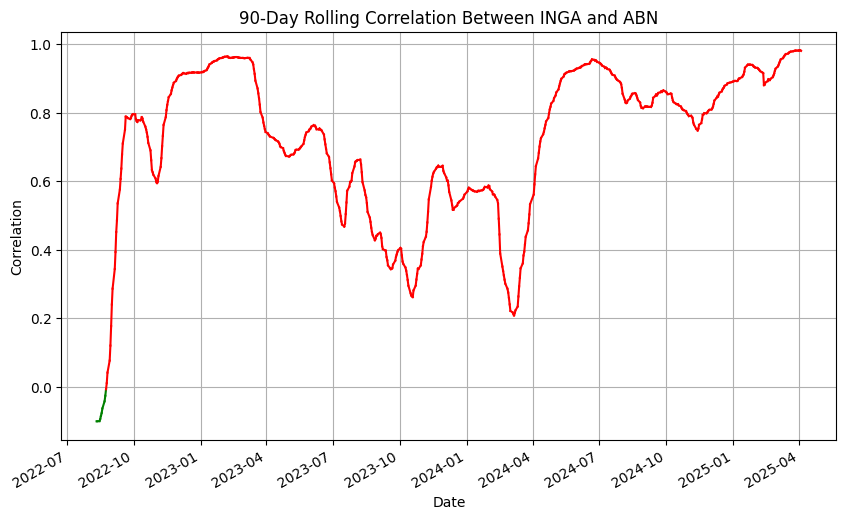

In [23]:
# Calculate the start date for the last 3 years
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=3 * 365)


# Define stock details
stock1 = "INGA"
exchange1 = "AS"
stock2 = "ABN"
exchange2 = "AS"
period = "d"

# Function to fetch historical prices and plot rolling correlation
def plot_rolling_correlation(stock1, exchange1, stock2, exchange2, start_date, end_date, window=90):
    # Fetch historical prices for both stocks
    stock1_df = Fetch_historical_price(stock1, exchange1, start_date, end_date, period, API_Eodhd)
    stock2_df = Fetch_historical_price(stock2, exchange2, start_date, end_date, period, API_Eodhd)

    # Ensure both DataFrames have a 'date' column and convert it to datetime
    stock1_df['date'] = pd.to_datetime(stock1_df['date'])
    stock2_df['date'] = pd.to_datetime(stock2_df['date'])

    # Sort the DataFrames by date and set the 'date' column as the index
    stock1_df = stock1_df.sort_values(by='date').set_index('date')
    stock2_df = stock2_df.sort_values(by='date').set_index('date')

    # Align the two DataFrames on their dates
    combined_df = pd.concat([stock1_df['adjusted_close'], stock2_df['adjusted_close']], axis=1, keys=['Stock1', 'Stock2']).dropna()

    # Calculate rolling correlation
    rolling_corr = combined_df['Stock1'].rolling(window=window).corr(combined_df['Stock2'])

    # Plot the rolling correlation with color based on value
    plt.figure(figsize=(10, 6))
    for i in range(1, len(rolling_corr)):
        if rolling_corr[i] > 0:
            plt.plot(rolling_corr.index[i-1:i+1], rolling_corr[i-1:i+1], color='red')
        else:
            plt.plot(rolling_corr.index[i-1:i+1], rolling_corr[i-1:i+1], color='green')

    plt.title(f'{window}-Day Rolling Correlation Between {stock1} and {stock2}')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.grid()

    # Format the date axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 12 months
    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

    plt.show()

# Call the function to plot the rolling correlation
plot_rolling_correlation(stock1, exchange1, stock2, exchange2, start_date, end_date, window=90)

C:\Users\ravit\AppData\Local\Temp\ipykernel_40020\3169846915.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rolling_corr[i] > 0:


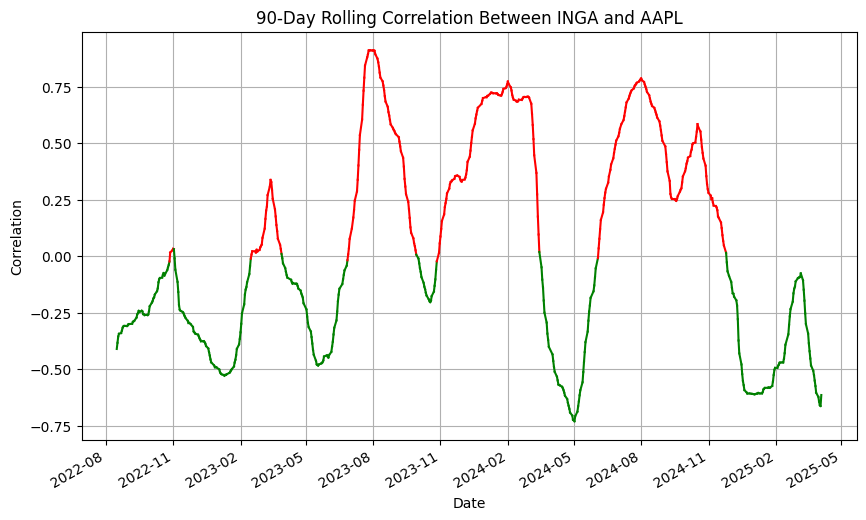

C:\Users\ravit\AppData\Local\Temp\ipykernel_40020\3169846915.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if rolling_corr[i] > 0:


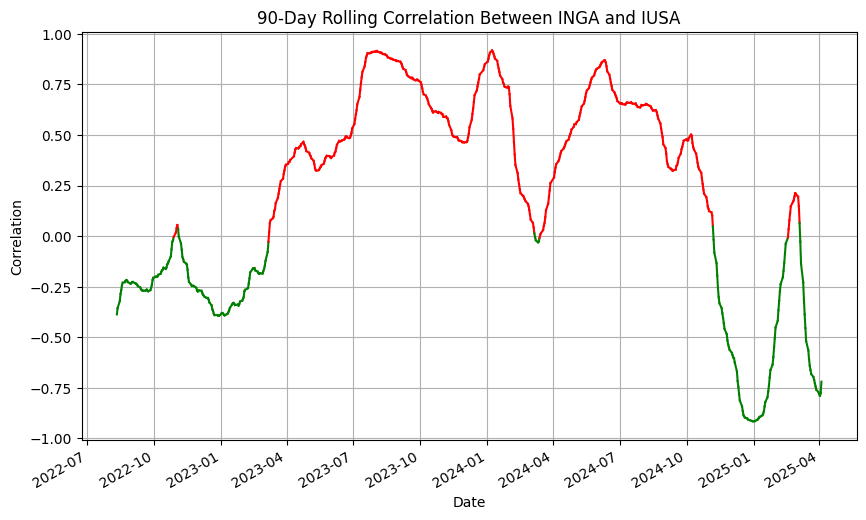

In [28]:
#plotting multiple rolling correlations

plot_rolling_correlation("INGA", "AS", "AAPL", "US", start_date, end_date, window=90)
plot_rolling_correlation("INGA", "AS", "IUSA", "AS", start_date, end_date, window=90)